In [1]:
%cd /content/drive/MyDrive/agender/model/Secondary

/content/drive/MyDrive/agender/model/Secondary


In [66]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pandas as pd
from PIL import Image
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import math
import torch

In [44]:
# テストデータ
img_files_female = glob("/content/drive/MyDrive/agender/model/Secondary/Dataset/All-Age-Faces-Dataset/split_dataset_gender/test/female/*")
img_files_male = glob("/content/drive/MyDrive/agender/model/Secondary/Dataset/All-Age-Faces-Dataset/split_dataset_gender/test/male/*")
len(img_files_female), len(img_files_male)

(287, 287)

# YOLOv8s

In [57]:
def get_img_yolo(img_file):
  img_size = 224
  stride = 32

  img = cv2.imread(img_file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  imh, imw = img.shape[:2]
  r = min(img_size / imh, img_size / imw)
  h, w = round(imh * r), round(imw * r)
  hs, ws = (math.ceil(x / stride) * stride for x in (h, w))
  top, left = round((hs - h) / 2 - 0.1), round((ws - w) / 2 - 0.1)
  img_pad = np.full((img_size, img_size, 3), 114, dtype=img.dtype)
  img_pad[top:top + h, left:left + w] = cv2.resize(img, (w, h), interpolation=cv2.INTER_LINEAR)


  img_norm = img_pad/255

  face = np.empty((1, img_size, img_size, 3))
  face[0,:,:,:] = img_norm
  face = np.transpose(face, (0, 3, 1, 2))

  return torch.from_numpy(face.astype(np.float32)).clone()


In [45]:
def prediction_yolo(img_files, model):

  pred_list = []
  gt_list = []

  for img_file in img_files:
    img = get_img_yolo(img_file)
    pred = model(img)
    class_id = np.argmax(pred)

    if class_id == 0:
      pred_gender = "female"
    else:
      pred_gender = "male"

    if int(os.path.basename(img_file).split("A")[0]) <= 7380:
      gt_gender = "female"
    else:
      gt_gender = "male"

    pred_list.append(pred_gender)
    gt_list.append(gt_gender)

  return gt_list, pred_list

In [20]:
def cal_accuracy(gt, pred, is_confusion_matrix):
  accuracy = accuracy_score(gt, pred)
  print("accuracy: ", accuracy)

  if is_confusion_matrix:
    cm = confusion_matrix(gt, pred, labels=["female", "male"])
    sns.heatmap(cm, annot=True, cmap='Blues')

In [ ]:
!pip3 install ultralytics

from ultralytics import YOLO
import torch

female
accuracy:  0.9407665505226481
male
accuracy:  0.8954703832752613
all
accuracy:  0.9181184668989547


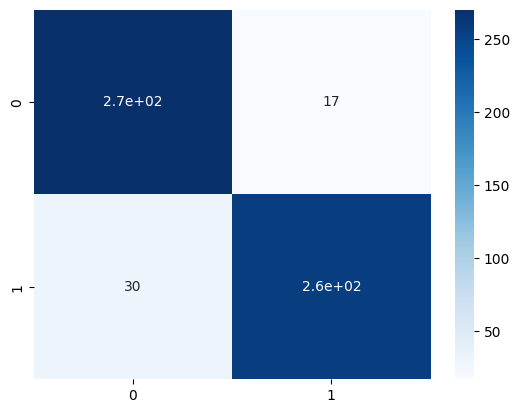

In [64]:
# load model
model_file_path = "/content/drive/MyDrive/agender/model/Secondary/YOLOv8/ultralytics/runs/classify/gender2/weights/best.pt"
model = YOLO(model_file_path)

# inference
# female
print("female")
gt_female, pred_female = prediction_yolo(img_files_female, model.model.eval())
cal_accuracy(gt_female, pred_female, is_confusion_matrix=False)
# male
print("male")
gt_male, pred_male = prediction_yolo(img_files_male, model.model.eval())
cal_accuracy(gt_male, pred_male, is_confusion_matrix=False)
# all
print("all")
gt_female.extend(gt_male)
pred_female.extend(pred_male)
cal_accuracy(gt_female, pred_female, is_confusion_matrix=True)

# MobileNetv3 small

In [68]:
import tensorflow as tf

In [78]:
def get_img_mnv3(img_file):
  img_size = 224

  img = Image.open(img_file)

  face = np.empty((1, img_size, img_size, 3))
  face[0,:,:,:] = img.resize((img_size,img_size), resample=Image.NEAREST)

  return face

In [80]:
def prediction_mnv3(img_files, model):

  pred_list = []
  gt_list = []

  for img_file in img_files:
    img = get_img_mnv3(img_file)
    pred = model.predict(img, verbose=0)

    if pred < 0.5:
      pred_gender = "female"
    else:
      pred_gender = "male"

    if int(os.path.basename(img_file).split("A")[0]) <= 7380:
      gt_gender = "female"
    else:
      gt_gender = "male"

    pred_list.append(pred_gender)
    gt_list.append(gt_gender)

  return gt_list, pred_list

female
accuracy:  0.8885017421602788
male
accuracy:  0.9442508710801394
all
accuracy:  0.9163763066202091


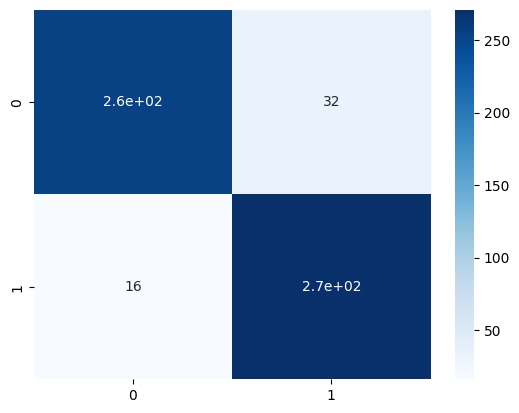

In [81]:
# load model
model_file_path = "/content/drive/MyDrive/agender/model/Secondary/MobileNetv3/20230603_TF/247-0.92969-0.64230"
model = tf.keras.models.load_model(model_file_path)

# inference
# female
print("female")
gt_female, pred_female = prediction_mnv3(img_files_female, model)
cal_accuracy(gt_female, pred_female, is_confusion_matrix=False)
# male
print("male")
gt_male, pred_male = prediction_mnv3(img_files_male, model)
cal_accuracy(gt_male, pred_male, is_confusion_matrix=False)
# all
print("all")
gt_female.extend(gt_male)
pred_female.extend(pred_male)
cal_accuracy(gt_female, pred_female, is_confusion_matrix=True)